For this notebook I took some ideas from the following work: https://www.kaggle.com/code/cereniyim/fantastic-trees-where-to-find-how-to-detect-them/notebook

In [45]:
# for data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 60)

# for visualization
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
# to include graphs inline within the frontends next to code
import seaborn as sns
sns.set_context(font_scale=2)

# to bypass warnings in various dataframe assignments
pd.options.mode.chained_assignment = None
# machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# preprocessing functions and evaluation models
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler

# Data exploration


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.options.display.max_columns = 99
np.random.seed(0)

In [2]:
ls

__notebook_source__.ipynb


In [3]:
import zipfile

unzip_data_1 = "../input/forest-cover-type-kernels-only/train.csv.zip"
unzip_data_2 = "../input/forest-cover-type-kernels-only/test.csv.zip"
cdir = "./"

with zipfile.ZipFile(unzip_data_1, 'r') as zip_ref_1:
    zip_ref_1.extractall(cdir)
    
with zipfile.ZipFile(unzip_data_2, 'r') as zip_ref_2:
    zip_ref_2.extractall(cdir)

In [4]:
ls

__notebook_source__.ipynb  test.csv  train.csv


In [5]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

In [6]:
train_data.head(20)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
5,6,2579,132,6,300,-15,67,230,237,140,6031,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
6,7,2606,45,7,270,5,633,222,225,138,6256,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
7,8,2605,49,4,234,7,573,222,230,144,6228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
8,9,2617,45,9,240,56,666,223,221,133,6244,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
9,10,2612,59,10,247,11,636,228,219,124,6230,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


First we see, that Soil types and Wilderness areas are one-hot encoded versions of categorical variables. The others are continuous.

In [20]:
train_try = train_data.copy()

In [21]:
train_try.columns[11:55]

Index(['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

In [22]:
def split_numbers_chars(row):
    '''This function fetches the numerical characters at the end of a string
    and returns alphabetical character and numerical chaarcters respectively'''
    head = row.rstrip('0123456789')
    tail = row[len(head):]
    return head, tail

def reverse_one_hot_encode(dataframe, start_loc, end_loc, numeric_column_name):
    ''' this function takes the start and end location of the one-hot-encoded column set and numeric column name to be created as arguments
    1) transforms one-hot-encoded columns into one column consisting of column names with string data type
    2) splits string column into the alphabetical and numerical characters
    3) fetches numerical character and creates numeric column in the given dataframe
    '''
    dataframe['String_Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1).idxmax(1)
    dataframe['Tuple_Column'] = dataframe['String_Column'].apply(split_numbers_chars)
    dataframe[numeric_column_name] = dataframe['Tuple_Column'].apply(lambda x: x[1]).astype('int64')
    dataframe.drop(columns=['String_Column','Tuple_Column'], inplace=True)

In [23]:
reverse_one_hot_encode(train_try, 15, 55, "Soil_Type")
reverse_one_hot_encode(train_try, 11, 15, "Wilderness_Area")
train_try.drop(train_try.iloc[:,11:55], axis=1, inplace=True)

In [24]:
train_try

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area
0,1,2596,51,3,258,0,510,221,232,148,6279,5,29,1
1,2,2590,56,2,212,-6,390,220,235,151,6225,5,29,1
2,3,2804,139,9,268,65,3180,234,238,135,6121,2,12,1
3,4,2785,155,18,242,118,3090,238,238,122,6211,2,30,1
4,5,2595,45,2,153,-1,391,220,234,150,6172,5,29,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,1282,3,4,3
15116,15117,2603,121,19,633,195,618,249,221,91,1325,3,4,3
15117,15118,2492,134,25,365,117,335,250,220,83,1187,3,4,3
15118,15119,2487,167,28,218,101,242,229,237,119,932,3,4,3


In [12]:
def get_categorical(df):
    '''Creates categorical column for:
        Wilderness_Area and Soil_Type.'''

    df['Soil_Type']='' 
    for col_name in df.columns[15:55]:
        df.loc[df[col_name]==1,'Soil_Type'] = col_name
    
    df['Wilderness_Area']='' 
    for col_name in df.columns[11:15]:
        df.loc[df[col_name]==1,'Wilderness_Area'] = col_name

    return df.drop(df.iloc[:,11:55], axis=1)

def feature_engines(df):
    '''
    Coming from: https://www.kaggle.com/code/cereniyim/fantastic-trees-where-to-find-how-to-detect-them/notebook
    '''
    
    df["Euclidian_Distance_To_Hydrology"] = (df["Horizontal_Distance_To_Hydrology"]**2 + df["Vertical_Distance_To_Hydrology"]**2)**0.5
    df['Mean_Elevation_Vertical_Distance_Hydrology'] = (df['Elevation'] + df['Vertical_Distance_To_Hydrology'])/2
    df['Mean_Distance_Hydrology_Firepoints'] = (df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points'])/2
    df['Mean_Distance_Hydrology_Roadways'] = (df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])/2
    df['Mean_Distance_Firepoints_Roadways'] = (df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])/2
    
    return df


def sqrt_tfm(df):
    '''Coming from: https://www.kaggle.com/code/cereniyim/fantastic-trees-where-to-find-how-to-detect-them/notebook'''
    
    # add sqrt transformed columns to the trees_w_numeric_soil dataframe
    for col in df.columns:
        if col in ['Cover_Type','Id','Wilderness_Area','Soil_Type']:
            next
        else:
            if df[col].min() >= 0:
                df['sqrt_' + col] = np.sqrt(df[col])
            else:
                next
    return df


In [25]:
#train_try_new = get_categorical(train_try)     # only takes them into str... 
train_try = feature_engines(train_try)
train_try = sqrt_tfm(train_try)

In [26]:
train_try

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area,Euclidian_Distance_To_Hydrology,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways,sqrt_Elevation,sqrt_Aspect,sqrt_Slope,sqrt_Horizontal_Distance_To_Hydrology,sqrt_Horizontal_Distance_To_Roadways,sqrt_Hillshade_9am,sqrt_Hillshade_Noon,sqrt_Hillshade_3pm,sqrt_Horizontal_Distance_To_Fire_Points,sqrt_Euclidian_Distance_To_Hydrology,sqrt_Mean_Elevation_Vertical_Distance_Hydrology,sqrt_Mean_Distance_Hydrology_Firepoints,sqrt_Mean_Distance_Hydrology_Roadways,sqrt_Mean_Distance_Firepoints_Roadways
0,1,2596,51,3,258,0,510,221,232,148,6279,5,29,1,258.000000,1298.0,3268.5,384.0,3394.5,50.950957,7.141428,1.732051,16.062378,22.583180,14.866069,15.231546,12.165525,79.240141,16.062378,36.027767,57.170797,19.595918,58.262338
1,2,2590,56,2,212,-6,390,220,235,151,6225,5,29,1,212.084889,1292.0,3218.5,301.0,3307.5,50.892043,7.483315,1.414214,14.560220,19.748418,14.832397,15.329710,12.288206,78.898669,14.563135,35.944402,56.731825,17.349352,57.510869
2,3,2804,139,9,268,65,3180,234,238,135,6121,2,12,1,275.769832,1434.5,3194.5,1724.0,4650.5,52.952809,11.789826,3.000000,16.370706,56.391489,15.297059,15.427249,11.618950,78.236820,16.606319,37.874794,56.519908,41.521079,68.194575
3,4,2785,155,18,242,118,3090,238,238,122,6211,2,30,1,269.235956,1451.5,3226.5,1666.0,4650.5,52.773099,12.449900,4.242641,15.556349,55.587768,15.427249,15.427249,11.045361,78.809898,16.408411,38.098556,56.802289,40.816663,68.194575
4,5,2595,45,2,153,-1,391,220,234,150,6172,5,29,1,153.003268,1297.0,3162.5,272.0,3281.5,50.941143,6.708204,1.414214,12.369317,19.773720,14.832397,15.297059,12.247449,78.562077,12.369449,36.013886,56.236109,16.492423,57.284378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,1282,3,4,3,258.094944,1307.0,770.0,459.0,971.0,51.058790,15.588457,4.795832,16.062378,25.690465,13.038405,15.842980,14.628739,35.805028,16.065334,36.152455,27.748874,21.424285,31.160873
15116,15117,2603,121,19,633,195,618,249,221,91,1325,3,4,3,662.354890,1399.0,979.0,625.5,971.5,51.019604,11.000000,4.358899,25.159491,24.859606,15.779734,14.866069,9.539392,36.400549,25.736256,37.403208,31.288976,25.009998,31.168895
15117,15118,2492,134,25,365,117,335,250,220,83,1187,3,4,3,383.293621,1304.5,776.0,350.0,761.0,49.919936,11.575837,5.000000,19.104973,18.303005,15.811388,14.832397,9.110434,34.452866,19.577886,36.117863,27.856777,18.708287,27.586228
15118,15119,2487,167,28,218,101,242,229,237,119,932,3,4,3,240.260276,1294.0,575.0,230.0,587.0,49.869831,12.922848,5.291503,14.764823,15.556349,15.132746,15.394804,10.908712,30.528675,15.500331,35.972211,23.979158,15.165751,24.228083


In [27]:
train_try.dtypes

Id                                                   int64
Elevation                                            int64
Aspect                                               int64
Slope                                                int64
Horizontal_Distance_To_Hydrology                     int64
Vertical_Distance_To_Hydrology                       int64
Horizontal_Distance_To_Roadways                      int64
Hillshade_9am                                        int64
Hillshade_Noon                                       int64
Hillshade_3pm                                        int64
Horizontal_Distance_To_Fire_Points                   int64
Cover_Type                                           int64
Soil_Type                                            int64
Wilderness_Area                                      int64
Euclidian_Distance_To_Hydrology                    float64
Mean_Elevation_Vertical_Distance_Hydrology         float64
Mean_Distance_Hydrology_Firepoints                 float

In [29]:
# get the number of missing data points per column
missing_values_count = train_try.isnull().sum()
missing_values_count

Id                                                 0
Elevation                                          0
Aspect                                             0
Slope                                              0
Horizontal_Distance_To_Hydrology                   0
Vertical_Distance_To_Hydrology                     0
Horizontal_Distance_To_Roadways                    0
Hillshade_9am                                      0
Hillshade_Noon                                     0
Hillshade_3pm                                      0
Horizontal_Distance_To_Fire_Points                 0
Cover_Type                                         0
Soil_Type                                          0
Wilderness_Area                                    0
Euclidian_Distance_To_Hydrology                    0
Mean_Elevation_Vertical_Distance_Hydrology         0
Mean_Distance_Hydrology_Firepoints                 0
Mean_Distance_Hydrology_Roadways                   0
Mean_Distance_Firepoints_Roadways             

No missing value to handle.

In [ ]:
train_data.shape, test_data.shape

In [ ]:
train_data.describe()

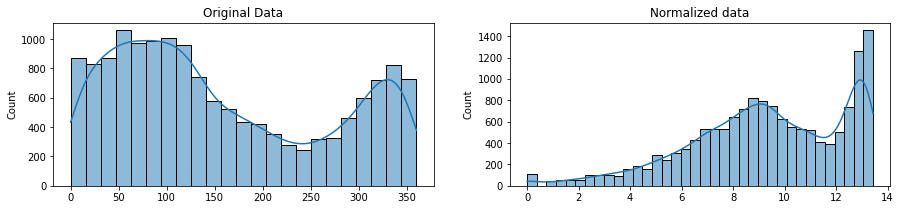

In [31]:
from scipy import stats
from scipy.special import boxcox1p
import seaborn as sns
import matplotlib.pyplot as plt

original_data = abs(train_data.Aspect.values)

# normalize the exponential data with boxcox
normalized_data = boxcox1p(original_data, 0.25)

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(normalized_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Normalized data")
plt.show()

In [ ]:
LogAspect = train_data.Aspect.apply(np.log1p)
SqrtAspect = train_data.Aspect.apply(np.sqrt)

# Plot a comparison
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].set_title("Aspect")
axs[1].set_title('LogAspect')
axs[2].set_title('SqrtAspect')
sns.kdeplot(train_data.Aspect, shade=True, ax=axs[0])
sns.kdeplot(LogAspect, shade=True, ax=axs[1])
sns.kdeplot(SqrtAspect, shade=True, ax=axs[2]);

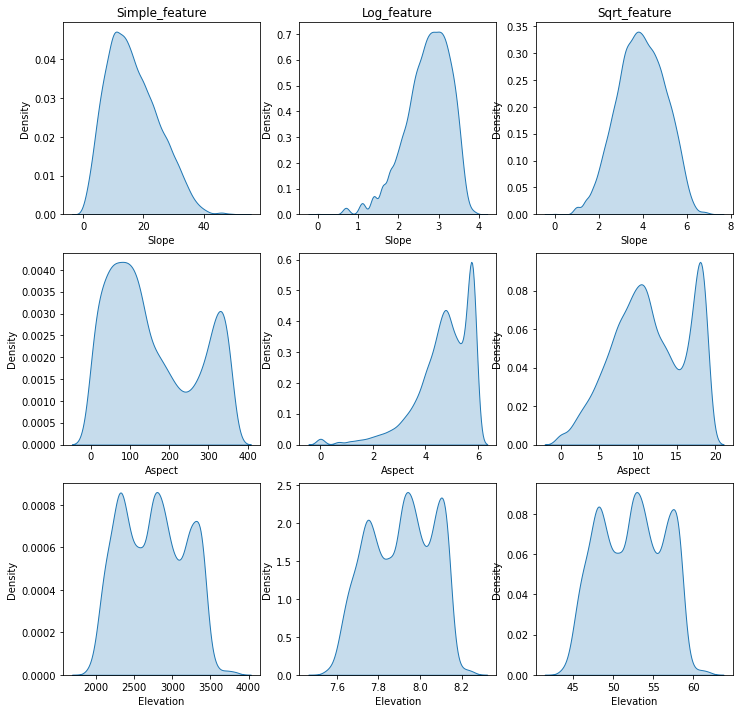

In [38]:
LogSlope = train_data.Slope.apply(np.log1p)
SqrtSlope = train_data.Slope.apply(np.sqrt)
LogAspect = train_data.Aspect.apply(np.log1p)
SqrtAspect = train_data.Aspect.apply(np.sqrt)
LogElevation = train_data.Elevation.apply(np.log1p)
SqrtElevation = train_data.Elevation.apply(np.sqrt)

# Plot a comparison
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs[0,0].set_title("Simple_feature")
axs[0,1].set_title('Log_feature')
axs[0,2].set_title('Sqrt_feature')

sns.kdeplot(train_data.Slope, shade=True, ax=axs[0,0])
sns.kdeplot(LogSlope, shade=True, ax=axs[0,1])
sns.kdeplot(SqrtSlope, shade=True, ax=axs[0,2])
sns.kdeplot(train_data.Aspect, shade=True, ax=axs[1,0])
sns.kdeplot(LogAspect, shade=True, ax=axs[1,1])
sns.kdeplot(SqrtAspect, shade=True, ax=axs[1,2])
sns.kdeplot(train_data.Elevation, shade=True, ax=axs[2,0])
sns.kdeplot(LogElevation, shade=True, ax=axs[2,1])
sns.kdeplot(SqrtElevation, shade=True, ax=axs[2,2]);

So except Soil_Type7, and Soil_Type15 every soil type has at least one sample.
That means these two columns can be dropped, and also ID, that wont be used either.

Another way to explore it is with correlation matrix. It also shows that these 2 features are useless:

<AxesSubplot:>

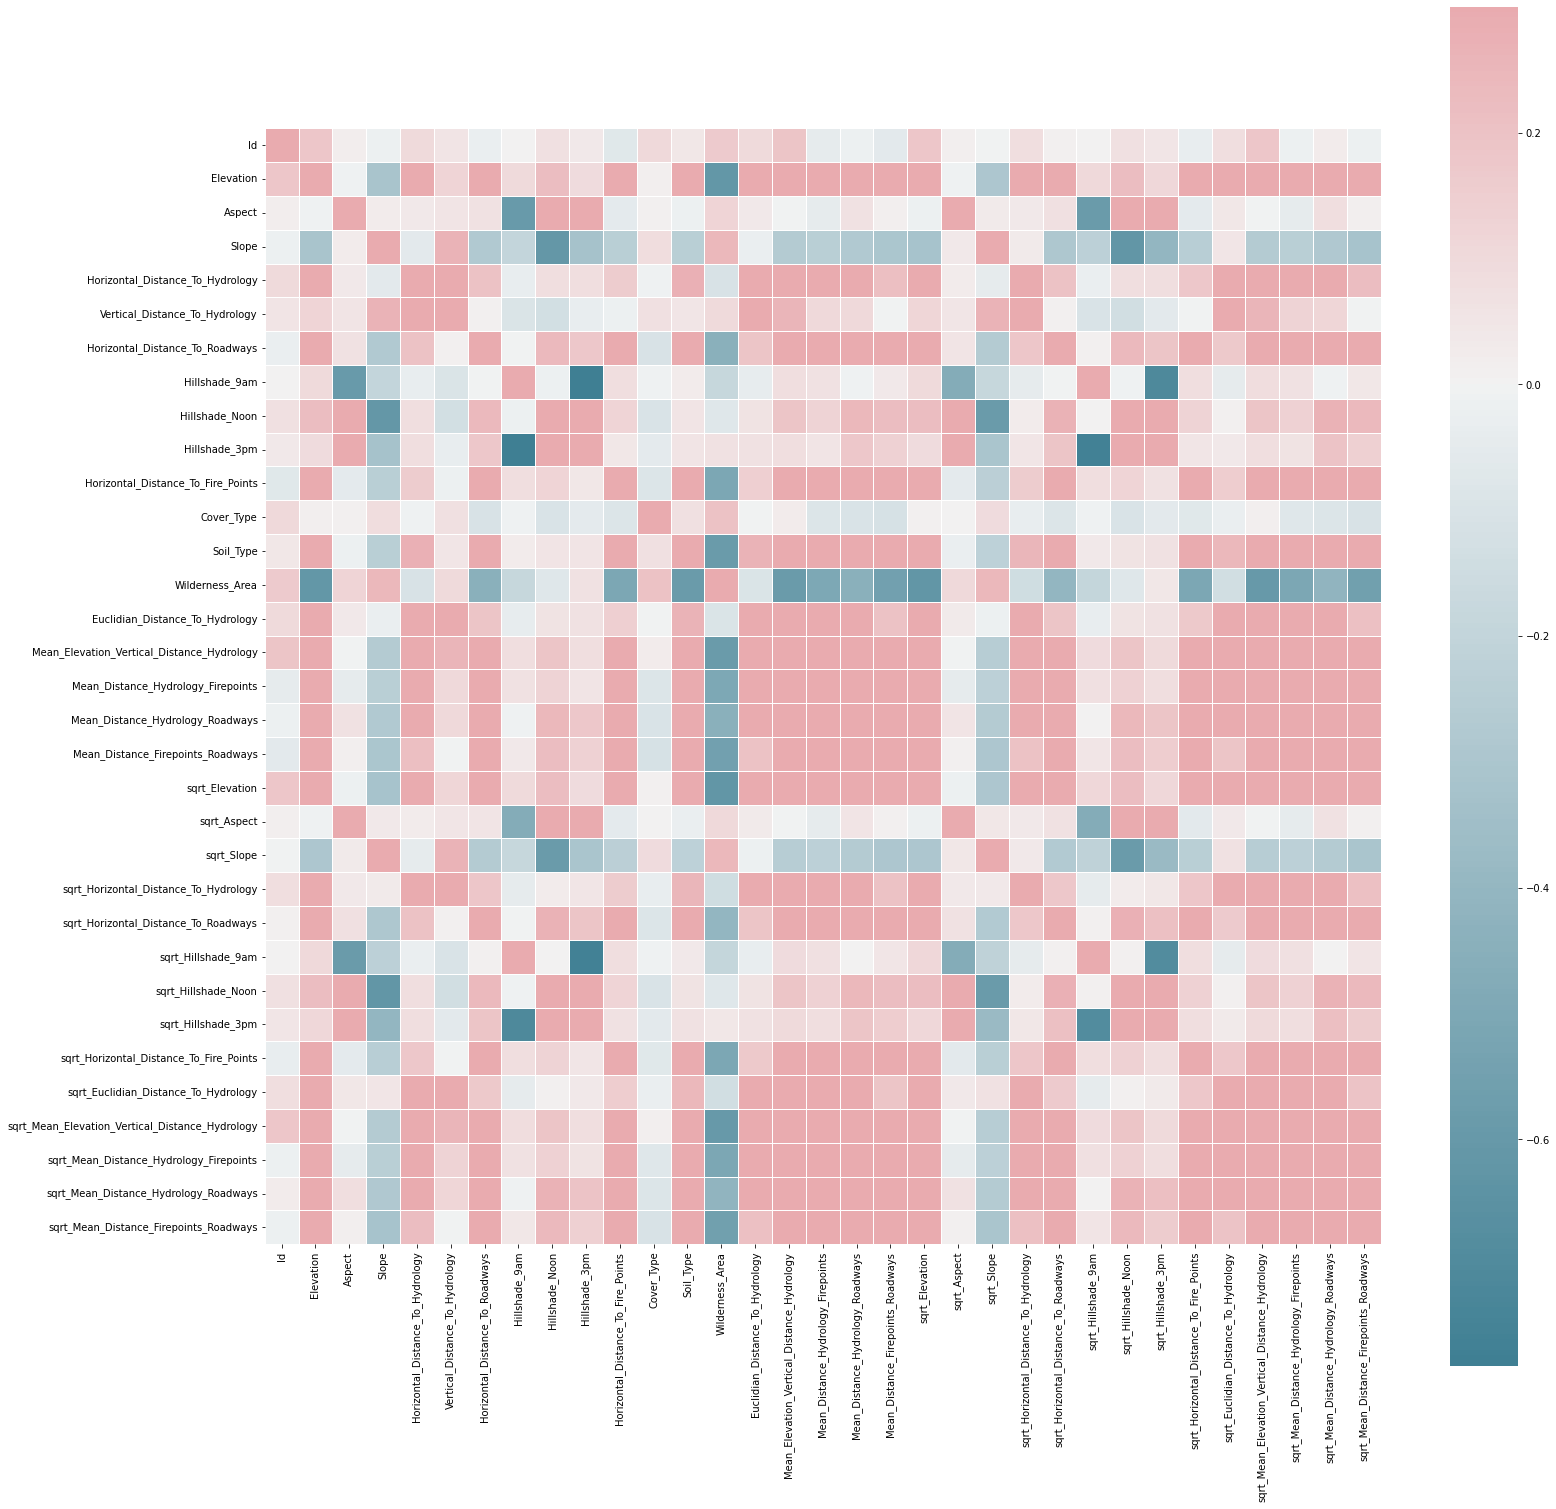

In [32]:
corr = train_try.corr()
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

In [33]:
corr

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type,Wilderness_Area,Euclidian_Distance_To_Hydrology,Mean_Elevation_Vertical_Distance_Hydrology,Mean_Distance_Hydrology_Firepoints,Mean_Distance_Hydrology_Roadways,Mean_Distance_Firepoints_Roadways,sqrt_Elevation,sqrt_Aspect,sqrt_Slope,sqrt_Horizontal_Distance_To_Hydrology,sqrt_Horizontal_Distance_To_Roadways,sqrt_Hillshade_9am,sqrt_Hillshade_Noon,sqrt_Hillshade_3pm,sqrt_Horizontal_Distance_To_Fire_Points,sqrt_Euclidian_Distance_To_Hydrology,sqrt_Mean_Elevation_Vertical_Distance_Hydrology,sqrt_Mean_Distance_Hydrology_Firepoints,sqrt_Mean_Distance_Hydrology_Roadways,sqrt_Mean_Distance_Firepoints_Roadways
Id,1.000000,0.185496,0.017702,-0.020168,0.099637,0.055348,-0.033028,0.000786,0.073123,0.042524,-0.068739,0.108363,0.044650,0.167781,0.097737,0.188292,-0.047458,-0.016508,-0.057016,0.183773,0.016708,-0.007091,0.081441,0.011447,0.004235,0.073840,0.051911,-0.036700,0.079115,0.185857,-0.018812,0.022112,-0.020388
Elevation,0.185496,1.000000,-0.011096,-0.312640,0.412712,0.122092,0.578659,0.097900,0.215782,0.089518,0.443563,0.016090,0.826721,-0.616460,0.400237,0.989935,0.498725,0.617032,0.599260,0.999335,-0.011668,-0.295206,0.410053,0.589983,0.108614,0.216418,0.110603,0.479676,0.396464,0.990136,0.537478,0.637262,0.639909
Aspect,0.017702,-0.011096,1.000000,0.028148,0.040732,0.056412,0.066184,-0.593997,0.324912,0.635022,-0.052169,0.008015,-0.012270,0.126366,0.042196,-0.002747,-0.042379,0.069590,0.014480,-0.013280,0.976666,0.031413,0.041943,0.075516,-0.588718,0.321193,0.564830,-0.052612,0.043314,-0.004860,-0.042864,0.077288,0.014707
Slope,-0.020168,-0.312640,0.028148,1.000000,-0.055976,0.265314,-0.277049,-0.200072,-0.612613,-0.326887,-0.239527,0.087722,-0.238523,0.245179,-0.030351,-0.266219,-0.238884,-0.273911,-0.301180,-0.316005,0.042403,0.985000,0.030496,-0.287006,-0.229596,-0.620752,-0.408612,-0.247679,0.055288,-0.269128,-0.241014,-0.282423,-0.316070
Horizontal_Distance_To_Hydrology,0.099637,0.412712,0.040732,-0.055976,1.000000,0.652142,0.203397,-0.033803,0.080047,0.080833,0.158817,-0.010515,0.274427,-0.105571,0.998490,0.494362,0.333961,0.346731,0.212165,0.409299,0.028589,-0.043082,0.940278,0.201467,-0.028976,0.079409,0.082575,0.179854,0.936255,0.488561,0.365092,0.353577,0.220955
Vertical_Distance_To_Hydrology,0.055348,0.122092,0.056412,0.265314,0.652142,1.000000,0.011555,-0.095930,-0.132948,-0.035559,-0.015048,0.075647,0.048898,0.098159,0.689059,0.261328,0.104543,0.110116,-0.000593,0.117878,0.047933,0.264636,0.645514,0.009168,-0.102215,-0.134655,-0.061194,-0.003188,0.671771,0.254282,0.127880,0.115524,-0.000193
Horizontal_Distance_To_Roadways,-0.033028,0.578659,0.066184,-0.277049,0.203397,0.011555,1.000000,-0.003398,0.240684,0.173882,0.486386,-0.105662,0.467596,-0.448597,0.192008,0.564408,0.501441,0.988882,0.888420,0.577209,0.055873,-0.267506,0.182625,0.976291,0.007047,0.240804,0.187515,0.473168,0.171246,0.563477,0.486353,0.967244,0.877618
Hillshade_9am,0.000786,0.097900,-0.593997,-0.200072,-0.033803,-0.095930,-0.003398,1.000000,-0.013712,-0.779965,0.078144,-0.010286,0.026215,-0.186548,-0.039053,0.081532,0.068441,-0.008389,0.038903,0.101128,-0.472632,-0.188270,-0.044135,-0.005722,0.996827,-0.008757,-0.707442,0.076818,-0.049269,0.084864,0.067836,-0.009984,0.046358
Hillshade_Noon,0.073123,0.215782,0.324912,-0.612613,0.080047,-0.132948,0.240684,-0.013712,1.000000,0.614526,0.122098,-0.098905,0.058847,-0.079019,0.063424,0.190896,0.131163,0.242730,0.216472,0.219287,0.371897,-0.582681,0.028164,0.269924,0.002737,0.998972,0.642871,0.129481,0.011879,0.194079,0.135218,0.268170,0.236858
Hillshade_3pm,0.042524,0.089518,0.635022,-0.326887,0.080833,-0.035559,0.173882,-0.779965,0.614526,1.000000,0.043162,-0.053399,0.057211,0.065279,0.071883,0.081988,0.055946,0.178854,0.132724,0.089451,0.555352,-0.311615,0.047669,0.193032,-0.762232,0.6120

In [34]:
#train_data.drop(['Id'], inplace = True, axis = 1 )
#train_data.drop(['Soil_Type15' , "Soil_Type7"], inplace = True, axis = 1 )
#test_data.drop(['Soil_Type15' , "Soil_Type7"], inplace = True, axis = 1 )

train_try.drop(['Id'], inplace = True, axis = 1 )

# Feature Engineering

- determine which features are the most important with mutual information
- invent new features in for better performance
- encode high-cardinality categoricals with a target encoding
- create segmentation features with k-means clustering
- decompose a dataset's variation into features with principal component analysis


1. Mutual information:
    Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other.
    
- MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.


In [35]:
X = train_try.copy()
X.drop(columns=['Wilderness_Area', 'Soil_Type'], inplace=True)
y = X.pop("Cover_Type")

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes != object

In [36]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, n_neighbors=3)
    mi_scores = pd.Series(mi_scores, name="MI_Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/cluster/_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/opt/conda/l

Mean_Distance_Firepoints_Roadways                  1.183793
Elevation                                          1.148380
sqrt_Mean_Elevation_Vertical_Distance_Hydrology    1.067628
Mean_Distance_Hydrology_Roadways                   0.952826
sqrt_Horizontal_Distance_To_Roadways               0.749576
sqrt_Horizontal_Distance_To_Fire_Points            0.595629
Vertical_Distance_To_Hydrology                     0.162840
sqrt_Hillshade_9am                                 0.140947
Hillshade_3pm                                      0.118934
sqrt_Hillshade_Noon                                0.068199
Name: MI_Scores, dtype: float64

Well in our case the first 3 feature matters in MI (soil type as a whole would matter). Elevation has the best score so it determines the target the most.

In [39]:
# fantastic corr matrix:

correlations_transformed = pd.DataFrame(train_try.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["Cover_Type"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with Cover_Type"]
correlations_transformed = (correlations_transformed[correlations_transformed["Feature"] != "Cover_Type"]
                .sort_values(by="Correlation with Cover_Type", ascending=True))
display(correlations_transformed)

,Feature,Correlation with Cover_Type
17,Mean_Distance_Firepoints_Roadways,-0.113834
31,sqrt_Mean_Distance_Firepoints_Roadways,-0.107488
5,Horizontal_Distance_To_Roadways,-0.105662
16,Mean_Distance_Hydrology_Roadways,-0.102820
7,Hillshade_Noon,-0.098905
24,sqrt_Hillshade_Noon,-0.098473
30,sqrt_Mean_Distance_Hydrology_Roadways,-0.090889
9,Horizontal_Distance_To_Fire_Points,-0.089389
22,sqrt_Horizontal_Distance_To_Roadways,-0.087859
15,Mean_Distance_Hydrology_Firepoints,-0.087257


Separating final features

In [40]:
# final list of features
chosen_tfm_features = ['Mean_Distance_Firepoints_Roadways', 'sqrt_Mean_Elevation_Vertical_Distance_Hydrology', 'Mean_Distance_Hydrology_Roadways', 
                       'sqrt_Horizontal_Distance_To_Roadways', 'sqrt_Horizontal_Distance_To_Fire_Points', 'sqrt_Euclidian_Distance_To_Hydrology']

all_features =  (['sqrt_Elevation', 'sqrt_Aspect', 'sqrt_Slope', 'Vertical_Distance_To_Hydrology', 
                  'Hillshade_Noon', 'Hillshade_3pm' ] +
                 ['Soil_Type', 'Wilderness_Area'] + chosen_tfm_features)

# Training with 

In [42]:
trees_training = train_try[all_features]
labels_training = train_try["Cover_Type"]

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(trees_training, labels_training, test_size=0.2, random_state=1)

In [47]:
# Create dummy classifer
dummy = DummyClassifier(strategy='stratified', random_state=1)

# train the model
dummy.fit(X_train, y_train)

# Get accuracy score
baseline_accuracy = dummy.score(X_valid, y_valid)
print("Our dummy algorithm classified {:0.2f} of the of the trees correctly".format(baseline_accuracy))

Our dummy algorithm classified 0.14 of the of the trees correctly


# Z-Score normalization for K-Nearest Neighbors and LightGBM

In [48]:
# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X_train_scaled = scaler.fit_transform(X_train, y_train)

# transform validation set
X_valid_scaled = scaler.transform(X_valid)

In [49]:
# function to train a given model, generate predictions, and return accuracy score
def fit_evaluate_model(model, X_train, y_train, X_valid, Y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return accuracy_score(y_valid, y_predicted)

K-Nearest Neighbor Classifier:

In [50]:
# create model apply fit_evaluate_model
knn_classifier = KNeighborsClassifier()
knn_accuracy = fit_evaluate_model(knn_classifier, X_train_scaled, y_train, X_valid_scaled, y_valid)
print("Number of correct predictions made out of all predictions are:", knn_accuracy)

Number of correct predictions made out of all predictions are: 0.7959656084656085


Light Gradient Boosting Machine (LightGBM) Classifier:


In [51]:
# create model apply fit_evaluate_model
lgbm_classifier = LGBMClassifier()
lgbm_accuracy = fit_evaluate_model(lgbm_classifier, X_train_scaled, y_train, X_valid_scaled, y_valid)
print("Number of correct predictions made out of all predictions are:", lgbm_accuracy)

Number of correct predictions made out of all predictions are: 0.8627645502645502


Random Forest Classifier:

In [52]:
# create model apply fit_evaluate_model
rf_classifier = RandomForestClassifier()
rf_accuracy = fit_evaluate_model(rf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", rf_accuracy)

Number of correct predictions made out of all predictions are: 0.8703703703703703


Extra Trees (Random Forests) Classifier:

In [53]:
# create model apply fit_evaluate_model
xrf_classifier = ExtraTreesClassifier()
xrf_accuracy = fit_evaluate_model(xrf_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xrf_accuracy)

Number of correct predictions made out of all predictions are: 0.8895502645502645


Extra Gradient Boosting (XGBoost) Classifier:

In [54]:
# create model apply fit_evaluate_model
xgb_classifier = XGBClassifier()
xgb_accuracy = fit_evaluate_model(xgb_classifier, X_train, y_train, X_valid, y_valid)
print("Number of correct predictions made out of all predictions are:", xgb_accuracy)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:02:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Number of correct predictions made out of all predictions are: 0.8538359788359788


# Comparison of model performances

Text(0.5, 1.0, 'Accuracy Score of Different Models')

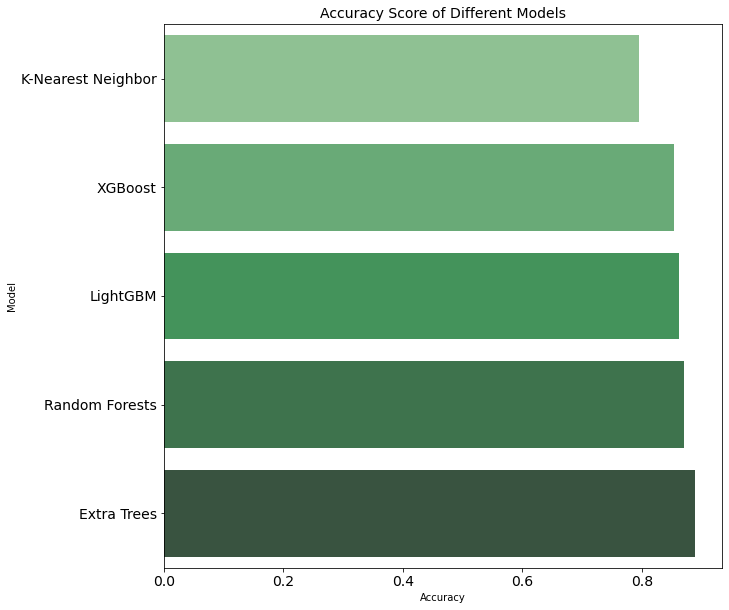

In [55]:
# create dataframe of accuracy and model and sort values
performance_comparison = pd.DataFrame({"Model": ["K-Nearest Neighbor", "LightGBM", "Random Forests", "Extra Trees", "XGBoost"],
                                       "Accuracy": [knn_accuracy, lgbm_accuracy, rf_accuracy, xrf_accuracy, xgb_accuracy]})

performance_comparison = performance_comparison.sort_values(by="Accuracy", ascending=True)

# set the plot
plt.figure(figsize=(10,10))
ax = sns.barplot(x="Accuracy", y="Model", data=performance_comparison, palette="Greens_d")

# set title arrange labels
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Accuracy Score of Different Models", size=14)

# Hyperparameter Tuning with Random Search and Cross-Validation

In [56]:
# The number of trees in the forest algorithm, default value is 10.
n_estimators = [50, 100, 300, 500, 1000]

# The minimum number of samples required to split an internal node, default value is 2.
min_samples_split = [2, 3, 5, 7, 9]

# The minimum number of samples required to be at a leaf node, default value is 1.
min_samples_leaf = [1, 2, 4, 6, 8]

# The number of features to consider when looking for the best split, default value is auto.
max_features = ['auto', 'sqrt', 'log2', None] 

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [57]:
# create model
best_model = ExtraTreesClassifier(random_state=42)

# create Randomized search object
random_cv = RandomizedSearchCV(estimator=best_model,
                               param_distributions=hyperparameter_grid,
                               cv=5, n_iter=20, 
                               scoring = 'accuracy',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True, 
                               random_state=42)

In [58]:
# Fit on the all training data using random search object
random_cv.fit(trees_training, labels_training)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


RandomizedSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 3, 5, 7, 9],
                                        'n_estimators': [50, 100, 300, 500,
                                                         1000]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=1)

In [59]:

random_cv.best_estimator_

ExtraTreesClassifier(max_features=None, n_estimators=300, random_state=42)

In [60]:
xrf_classifier_w_random_search = ExtraTreesClassifier(n_estimators=300, 
                                                     max_features=None, 
                                                     min_samples_leaf=1, 
                                                     min_samples_split=2,
                                                     random_state=42)

xrf_accuracy_opt_w_rand_search = fit_evaluate_model(xrf_classifier_w_random_search, X_train, y_train, X_valid, y_valid)


In [61]:
print("Accuracy score in the previous extra random forests model:", xrf_accuracy)
print("Accuracy score after hyperparameter tuning:", xrf_accuracy_opt_w_rand_search)

Accuracy score in the previous extra random forests model: 0.8895502645502645
Accuracy score after hyperparameter tuning: 0.8882275132275133


# 

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix

In [67]:
# create set of y_predictions
y_predicted = xrf_classifier.predict(X_valid)

# make a list of cover_types
cover_types = sorted(train_try['Cover_Type'].value_counts().index.tolist())

In [68]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    # else:
        # print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



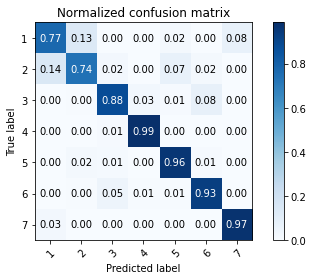

In [69]:
plot_confusion_matrix(y_valid, y_predicted, classes=cover_types, normalize=True,
                      title='Normalized confusion matrix')
plt.show()